# Homework 5: Weather Prediction

## Due Tues Mar 8, 2022 @ 8 pm

## Casey Lam, casey_lam@berkeley.edu

## Collaborators: #hw5-discussion channel

In this assignment we will create a database to analyze historical weather data and discovery the relationships between major cities.

### 1) Use the data supplied of airport codes (ICAO_airports.csv) and top airports (top_airports.csv) to make a table of 50 most travelled airports in the US and containing relevant information, like name, wikipedia link, latitude, longitude.

In [1]:
import pandas as pd
import sqlite3

Load up the supplied data and take a look at what's in the tables.

In [2]:
icao = pd.read_csv('ICAO_airports.csv')
top = pd.read_csv('top_airports.csv')

In [3]:
icao.head(5)

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords
0,6523,00A,heliport,Total Rf Heliport,40.070801,-74.933601,11.0,NaN,US,US-PA,Bensalem,no,00A,NaN,00A,NaN,NaN,NaN
1,6524,00AK,small_airport,Lowell Field,59.949200,-151.695999,450.0,NaN,US,US-AK,Anchor Point,no,00AK,NaN,00AK,NaN,NaN,NaN
2,6525,00AL,small_airport,Epps Airpark,34.864799,-86.770302,820.0,NaN,US,US-AL,Harvest,no,00AL,NaN,00AL,NaN,NaN,NaN
3,6526,00AR,heliport,Newport Hospital & Clinic Heliport,35.608700,-91.254898,237.0,NaN,US,US-AR,Newport,no,00AR,NaN,00AR,NaN,NaN,NaN
4,6527,00AZ,small_airport,Cordes Airport,34.305599,-112.165001,3810.0,NaN,US,US-AZ,Cordes,no,00AZ,NaN,00AZ,NaN,NaN,NaN


In [4]:
top.head(5)

,City,FAA,IATA,ICAO,Airport,Role,Enplanements
0,Atlanta,ATL,ATL,KATL,Hartsfield-Jackson Atlanta International Airport,P-L,43130585
1,Chicago,ORD,ORD,KORD,Chicago O'Hare International Airport,P-L,32171831
2,Los Angeles,LAX,LAX,KLAX,Los Angeles International Airport,P-L,30528737
3,Dallas-Fort Worth,DFW,DFW,KDFW,Dallas/Fort Worth International Airport,P-L,27100656
4,Denver,DEN,DEN,KDEN,Denver International Airport,P-L,25241962


Create the database, make two tables (icao, top), and put the relevant information from each csv file into the tables. 

In [5]:
!rm airports.db

connection = sqlite3.connect("airports.db")

cursor = connection.cursor()

sql_cmd = """CREATE TABLE icao 
            (iid INTEGER  NOT NULL  PRIMARY KEY  AUTOINCREMENT DEFAULT 0, 
            name TEXT, 
            wikipedia_link TEXT, 
            iata TEXT, 
            latitude_deg FLOAT, 
            longitude_deg FLOAT)"""

cursor.execute(sql_cmd)

sql_cmd = """CREATE TABLE top 
            (tid INTEGER  NOT NULL  PRIMARY KEY  AUTOINCREMENT DEFAULT 0, 
            name TEXT, 
            iata TEXT)"""

cursor.execute(sql_cmd)
connection.commit()

In [6]:
icao = icao.where(pd.notnull(icao), None)
for ii, row in icao.iterrows():
    iparams = (row['name'], row['wikipedia_link'], row['iata_code'], row['latitude_deg'], row['longitude_deg'])
    sql_cmd = """INSERT INTO icao
                (name, wikipedia_link, iata, latitude_deg, longitude_deg)
                VALUES (?, ?, ?, ?, ?)"""
    
    cursor.execute(sql_cmd, iparams)
connection.commit()

In [7]:
top = top.where(pd.notnull(top), None)
for ii, row in top.iterrows():
    iparams = (row['Airport'], row['IATA'])
    sql_cmd = """INSERT INTO top
                (name, iata)
                VALUES (?, ?)"""
    
    cursor.execute(sql_cmd, iparams)
connection.commit()    

In [8]:
# Just to see what happens.
# sql_cmd = "SELECT * FROM icao WHERE longitude_deg > 0"
# cursor.execute(sql_cmd)

# db_info = cursor.fetchall()
# for entry in db_info:
#     print(entry)

In [9]:
# Fix... figure out how to save this.
sql_cmd = """SELECT top.name, top.iata, icao.wikipedia_link, icao.latitude_deg, icao.longitude_deg
            FROM top LEFT JOIN icao ON
            top.iata = icao.iata"""

cursor.execute(sql_cmd)
db_info = cursor.fetchall()
print(len(db_info))
for entry in db_info: 
    print(entry)

50
('Hartsfield-Jackson Atlanta International Airport', 'ATL', 'http://en.wikipedia.org/wiki/Hartsfield-Jackson_Atlanta_International_Airport', 33.6366996765137, -84.4281005859375)
("Chicago O'Hare International Airport", 'ORD', "http://en.wikipedia.org/wiki/O'Hare_International_Airport", 41.97859955, -87.90480042)
('Los Angeles International Airport', 'LAX', 'http://en.wikipedia.org/wiki/Los_Angeles_International_Airport', 33.94250107, -118.4079971)
('Dallas/Fort Worth International Airport', 'DFW', 'http://en.wikipedia.org/wiki/Dallas-Fort_Worth_International_Airport', 32.896800994873, -97.0380020141602)
('Denver International Airport', 'DEN', 'http://en.wikipedia.org/wiki/Denver_International_Airport', 39.8616981506348, -104.672996520996)
('John F. Kennedy International Airport', 'JFK', 'http://en.wikipedia.org/wiki/John_F._Kennedy_International_Airport', 40.63980103, -73.77890015)
('San Francisco International Airport', 'SFO', 'http://en.wikipedia.org/wiki/San_Francisco_Internation

### 2) Build another table that will hold historical weather information: min/max temperature, relative humidity, and precipitation.

In [10]:
sql_cmd = """CREATE TABLE weather
            (wid INTEGER  NOT NULL  PRIMARY KEY  AUTOINCREMENT DEFAULT 0, 
            date DATE,
            lat FLOAT,
            long FLOAT,
            min_temp FLOAT,
            max_temp FLOAT,
            min_relhumid FLOAT,
            max_relhumid FLOAT,
            precip FLOAT)"""
cursor.execute(sql_cmd)
connection.commit()

### 3) Using the data from the xarray/netCDF4 example in class, populate the database from 1990-2000.

In [11]:
import xarray as xr
import numpy as np

Grab all the data we want (min/max temp, relative humidity, precipitation) from the online catalog.

In [12]:
# temp: tasmax/tasmin, RH: rhsmax/rhsmin, precipitation: pr
# downward shortwave solar radiation(rsds), eastward wind(uas), 
# northward wind(vas), and specific humidity(huss)

datatype = "tasmax" 

data_path = ("http://thredds.northwestknowledge.net:8080/"
             f"thredds/dodsC/agg_macav2metdata_{datatype}"
             "_BNU-ESM_r1i1p1_historical_1950_2005_CONUS_daily.nc")

max_temp_xr_all = xr.open_dataset(data_path)  
max_temp_xr = max_temp_xr_all['air_temperature'].sel(time=slice("1990", "2000"))

In [13]:
datatype = "tasmin" 

data_path = ("http://thredds.northwestknowledge.net:8080/"
             f"thredds/dodsC/agg_macav2metdata_{datatype}"
             "_BNU-ESM_r1i1p1_historical_1950_2005_CONUS_daily.nc")

min_temp_xr_all = xr.open_dataset(data_path)  
min_temp_xr = min_temp_xr_all['air_temperature'].sel(time=slice("1990", "2000"))

In [14]:
datatype = "rhsmax" 

data_path = ("http://thredds.northwestknowledge.net:8080/"
             f"thredds/dodsC/agg_macav2metdata_{datatype}"
             "_BNU-ESM_r1i1p1_historical_1950_2005_CONUS_daily.nc")

max_rhum_xr_all = xr.open_dataset(data_path) 
max_rhum_xr = max_rhum_xr_all['relative_humidity'].sel(time=slice("1990", "2000"))

In [15]:
datatype = "rhsmin" 

data_path = ("http://thredds.northwestknowledge.net:8080/"
             f"thredds/dodsC/agg_macav2metdata_{datatype}"
             "_BNU-ESM_r1i1p1_historical_1950_2005_CONUS_daily.nc")

min_rhum_xr_all = xr.open_dataset(data_path) 
min_rhum_xr = min_rhum_xr_all['relative_humidity'].sel(time=slice("1990", "2000"))

In [16]:
datatype = "pr" 

data_path = ("http://thredds.northwestknowledge.net:8080/"
             f"thredds/dodsC/agg_macav2metdata_{datatype}"
             "_BNU-ESM_r1i1p1_historical_1950_2005_CONUS_daily.nc")

precip_xr_all = xr.open_dataset(data_path) 
precip_xr = precip_xr_all['precipitation'].sel(time=slice("1990", "2000"))

Just get the longitudes and latitudes that match, otherwise it will take forever to make the database.

In [24]:
lon_arr = np.zeros(50)
lat_arr = np.zeros(50)
# Fix... figure out how to save this.
sql_cmd = """SELECT top.name, top.iata, icao.wikipedia_link, icao.latitude_deg, icao.longitude_deg
            FROM top LEFT JOIN icao ON
            top.iata = icao.iata"""

cursor.execute(sql_cmd)
db_info = cursor.fetchall()
print(len(db_info))
for ii, entry in enumerate(db_info): 
    lat_arr[ii] = entry[3]
    lon_arr[ii] = entry[4]

50


[24]
[24 35]


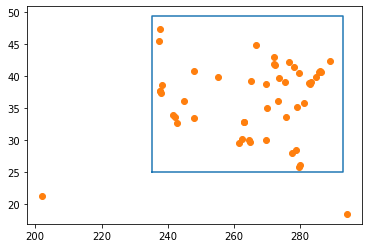

In [25]:
lon_idx_arr = []
lat_idx_arr = []

for ii, lon in enumerate(lon_arr):
    lon_idx_arr.append(np.abs(precip_xr['lon'].values - (lon + 360)).argmin())

for ii, lat in enumerate(lat_arr):
    lat_idx_arr.append(np.abs(precip_xr['lat'].values - lat).argmin())
    
# Note there are two places they don't match up. It's obvious when plotting.
#np.diff(precip_xr['lat']).mean()
#np.diff(precip_xr['lon']).mean()
print(np.where(precip_xr['lon'].values[lon_idx_arr] - (lon_arr + 360) > 0.04)[0])
print(np.where(precip_xr['lat'].values[lat_idx_arr] - lat_arr > 0.04)[0])

lonidx = np.where(precip_xr['lon'].values[lon_idx_arr] - (lon_arr + 360) > 0.04)[0]
latidx = np.where(precip_xr['lat'].values[lat_idx_arr] - lat_arr > 0.04)[0]

import matplotlib.pyplot as plt

plt.plot([precip_xr['lon'].min(), precip_xr['lon'].min(), precip_xr['lon'].max(), precip_xr['lon'].max(), precip_xr['lon'].min()],
         [precip_xr['lat'].min(), precip_xr['lat'].max(), precip_xr['lat'].max(), precip_xr['lat'].min(), precip_xr['lat'].min()])
plt.plot(lon_arr + 360, lat_arr, 'o')

In [26]:
float(min_temp_xr.isel(lon=500, lat=500).values[0])

270.2845153808594

Put into database.

In [33]:
# ~100 seconds to do 1/10 of the table.
import time
t1 = time.time()
for ii in np.arange(2):
    lon_idx = lon_idx_arr[ii]
    lat_idx = lat_idx_arr[ii]
    lat = min_temp_xr.isel(lon=lon_idx, lat=lat_idx)['lat'].values
    lon = min_temp_xr.isel(lon=lon_idx, lat=lat_idx)['lon'].values
    min_temp = min_temp_xr.isel(lon=lon_idx, lat=lat_idx).values
    max_temp = max_temp_xr.isel(lon=lon_idx, lat=lat_idx).values
    min_rhum = min_rhum_xr.isel(lon=lon_idx, lat=lat_idx).values
    max_rhum = max_rhum_xr.isel(lon=lon_idx, lat=lat_idx).values
    precip = precip_xr.isel(lon=lon_idx, lat=lat_idx).values
    for jj, time_xr in enumerate(precip_xr['time']):
        params = (str(time_xr.dt.strftime('%Y-%m-%d').values),
                  float(lat),
                  float(lon),
                  float(min_temp[jj]),
                  float(max_temp[jj]),
                  float(min_rhum[jj]),
                  float(max_rhum[jj]),
                  float(precip[jj]))
        sql_cmd = """INSERT INTO weather
                    (date, lat, long, min_temp, max_temp, min_relhumid, max_relhumid, precip)
                    VALUES (?, ?, ?, ?, ?, ?, ?, ?)"""
# Need to add lat, lon    
    
        cursor.execute(sql_cmd, params)
connection.commit()
t2 = time.time()

print(t2 - t1)

24.123267889022827


In [37]:
#Just to see what happens.
sql_cmd = "SELECT * FROM weather"
cursor.execute(sql_cmd)

db_info = cursor.fetchall()
for entry in db_info:
    print(entry)

(1, '1990-01-01', 33.64627456665039, 275.5605163574219, 273.0995788574219, 293.6379089355469, 23.176393508911133, 67.15652465820312, 0.0)
(2, '1990-01-02', 33.64627456665039, 275.5605163574219, 274.79522705078125, 295.29486083984375, 25.624561309814453, 62.87046813964844, 0.0)
(3, '1990-01-03', 33.64627456665039, 275.5605163574219, 278.93853759765625, 288.0876159667969, 43.65241241455078, 80.87677764892578, 7.232409477233887)
(4, '1990-01-04', 33.64627456665039, 275.5605163574219, 280.66754150390625, 287.15179443359375, 57.904476165771484, 79.01657104492188, 12.500265121459961)
(5, '1990-01-05', 33.64627456665039, 275.5605163574219, 276.63812255859375, 281.25531005859375, 60.34522247314453, 81.73420715332031, 2.3878254890441895)
(6, '1990-01-06', 33.64627456665039, 275.5605163574219, 273.8515930175781, 279.25860595703125, 44.78620147705078, 79.99336242675781, 0.0)
(7, '1990-01-07', 33.64627456665039, 275.5605163574219, 270.37908935546875, 278.0711364746094, 46.7891960144043, 87.1867904

(1816, '1994-12-21', 33.64627456665039, 275.5605163574219, 289.1556701660156, 296.8277587890625, 53.04435729980469, 82.8785629272461, 4.809454441070557)
(1817, '1994-12-22', 33.64627456665039, 275.5605163574219, 278.95367431640625, 294.1918640136719, 27.02266502380371, 71.36199951171875, 0.0)
(1818, '1994-12-23', 33.64627456665039, 275.5605163574219, 269.5803527832031, 281.78826904296875, 21.752450942993164, 62.45780563354492, 0.0)
(1819, '1994-12-24', 33.64627456665039, 275.5605163574219, 271.2090759277344, 281.5467224121094, 44.5428466796875, 82.21466064453125, 17.07256507873535)
(1820, '1994-12-25', 33.64627456665039, 275.5605163574219, 274.04437255859375, 284.5198059082031, 54.25846481323242, 98.37882995605469, 2.984346389770508)
(1821, '1994-12-26', 33.64627456665039, 275.5605163574219, 257.90771484375, 272.4871826171875, 31.524805068969727, 72.5806655883789, 0.0)
(1822, '1994-12-27', 33.64627456665039, 275.5605163574219, 261.8170166015625, 272.6500244140625, 21.112022399902344, 5

(3626, '1999-12-05', 33.64627456665039, 275.5605163574219, 280.3682861328125, 290.8476867675781, 57.76183319091797, 97.09818267822266, 22.790149688720703)
(3627, '1999-12-06', 33.64627456665039, 275.5605163574219, 283.5141296386719, 291.78399658203125, 44.946083068847656, 94.55287170410156, 9.555411338806152)
(3628, '1999-12-07', 33.64627456665039, 275.5605163574219, 280.44207763671875, 293.05792236328125, 50.14921951293945, 84.29431915283203, 0.0)
(3629, '1999-12-08', 33.64627456665039, 275.5605163574219, 286.7192077636719, 296.0081481933594, 54.65568161010742, 95.44963836669922, 5.160584449768066)
(3630, '1999-12-09', 33.64627456665039, 275.5605163574219, 277.61419677734375, 290.97454833984375, 37.4918327331543, 85.00450897216797, 8.811537742614746)
(3631, '1999-12-10', 33.64627456665039, 275.5605163574219, 274.15765380859375, 288.59588623046875, 37.70193099975586, 64.85139465332031, 0.0)
(3632, '1999-12-11', 33.64627456665039, 275.5605163574219, 276.0228271484375, 286.289794921875, 

(5315, '1993-07-20', 33.64627456665039, 275.5605163574219, 294.3244934082031, 304.58673095703125, 51.28499221801758, 99.98896026611328, 7.884809494018555)
(5316, '1993-07-21', 33.64627456665039, 275.5605163574219, 295.3550720214844, 305.1671447753906, 49.366981506347656, 99.99116516113281, 0.8635186553001404)
(5317, '1993-07-22', 33.64627456665039, 275.5605163574219, 295.98785400390625, 304.2288513183594, 50.65415954589844, 90.48944091796875, 1.4314931631088257)
(5318, '1993-07-23', 33.64627456665039, 275.5605163574219, 295.9201354980469, 304.3467102050781, 51.40406036376953, 99.99628448486328, 3.863881826400757)
(5319, '1993-07-24', 33.64627456665039, 275.5605163574219, 296.1546936035156, 305.13958740234375, 51.5467643737793, 99.9930191040039, 10.092568397521973)
(5320, '1993-07-25', 33.64627456665039, 275.5605163574219, 296.3817138671875, 306.15655517578125, 49.02815246582031, 91.79743194580078, 6.994974136352539)
(5321, '1993-07-26', 33.64627456665039, 275.5605163574219, 296.7091369

(7203, '1998-09-20', 33.64627456665039, 275.5605163574219, 295.9075622558594, 302.4944763183594, 51.96845626831055, 99.53154754638672, 0.0)
(7204, '1998-09-21', 33.64627456665039, 275.5605163574219, 294.5069580078125, 303.2312927246094, 47.13447570800781, 89.7704086303711, 0.0)
(7205, '1998-09-22', 33.64627456665039, 275.5605163574219, 293.61431884765625, 303.4454040527344, 45.36344528198242, 99.99282836914062, 0.0)
(7206, '1998-09-23', 33.64627456665039, 275.5605163574219, 293.2382507324219, 303.12689208984375, 46.58419418334961, 99.99474334716797, 0.0)
(7207, '1998-09-24', 33.64627456665039, 275.5605163574219, 292.5281677246094, 303.4975891113281, 47.2355842590332, 98.65193939208984, 0.0)
(7208, '1998-09-25', 33.64627456665039, 275.5605163574219, 294.2513427734375, 303.4226379394531, 48.668907165527344, 99.99183654785156, 0.7786931395530701)
(7209, '1998-09-26', 33.64627456665039, 275.5605163574219, 294.25604248046875, 302.80462646484375, 50.51995086669922, 99.99246978759766, 2.13025

(9168, '1993-02-05', 41.97947311401367, 272.10223388671875, 264.4334411621094, 273.9327087402344, 55.08038330078125, 82.34716796875, 0.0)
(9169, '1993-02-06', 41.97947311401367, 272.10223388671875, 265.6129150390625, 273.999267578125, 50.12824249267578, 88.79634857177734, 0.3465721011161804)
(9170, '1993-02-07', 41.97947311401367, 272.10223388671875, 266.02130126953125, 271.40631103515625, 44.92057418823242, 76.57295989990234, 0.0)
(9171, '1993-02-08', 41.97947311401367, 272.10223388671875, 257.791015625, 267.9051818847656, 45.803470611572266, 79.73433685302734, 0.0)
(9172, '1993-02-09', 41.97947311401367, 272.10223388671875, 260.9862976074219, 275.3651123046875, 38.146209716796875, 82.80096435546875, 0.0)
(9173, '1993-02-10', 41.97947311401367, 272.10223388671875, 268.5082092285156, 275.5186767578125, 32.68067169189453, 59.65372848510742, 0.0)
(9174, '1993-02-11', 41.97947311401367, 272.10223388671875, 269.4397888183594, 280.036865234375, 36.42988967895508, 67.40251159667969, 0.0)
(91

(11062, '1998-04-14', 41.97947311401367, 272.10223388671875, 281.25689697265625, 298.07861328125, 31.837907791137695, 77.15789031982422, 0.0)
(11063, '1998-04-15', 41.97947311401367, 272.10223388671875, 283.6957092285156, 295.089599609375, 28.210155487060547, 75.9301528930664, 0.8781303763389587)
(11064, '1998-04-16', 41.97947311401367, 272.10223388671875, 275.2027893066406, 287.3145751953125, 30.16917610168457, 66.23558807373047, 0.0)
(11065, '1998-04-17', 41.97947311401367, 272.10223388671875, 274.4066467285156, 289.75408935546875, 26.781524658203125, 58.589141845703125, 0.0)
(11066, '1998-04-18', 41.97947311401367, 272.10223388671875, 279.0950012207031, 291.5821838378906, 35.14371109008789, 65.35306549072266, 0.4106893539428711)
(11067, '1998-04-19', 41.97947311401367, 272.10223388671875, 279.7381896972656, 291.17572021484375, 34.422035217285156, 81.7535400390625, 0.0)
(11068, '1998-04-20', 41.97947311401367, 272.10223388671875, 281.8574523925781, 292.7186584472656, 33.1654052734375

(12982, '1992-07-16', 33.93793869018555, 241.6027374267578, 290.3144226074219, 296.54644775390625, 62.19997024536133, 94.74250793457031, 0.2876676321029663)
(12983, '1992-07-17', 33.93793869018555, 241.6027374267578, 290.60296630859375, 296.6250305175781, 62.21110534667969, 92.85284423828125, 0.4478524625301361)
(12984, '1992-07-18', 33.93793869018555, 241.6027374267578, 290.12591552734375, 297.0983581542969, 59.26942443847656, 91.18167114257812, 0.32535818219184875)
(12985, '1992-07-19', 33.93793869018555, 241.6027374267578, 290.2763671875, 298.2731018066406, 61.92106628417969, 91.63912963867188, 0.34309491515159607)
(12986, '1992-07-20', 33.93793869018555, 241.6027374267578, 290.43646240234375, 297.2218322753906, 61.30824279785156, 92.2765884399414, 0.0)
(12987, '1992-07-21', 33.93793869018555, 241.6027374267578, 290.791259765625, 296.46923828125, 61.72142028808594, 92.4078140258789, 0.0)
(12988, '1992-07-22', 33.93793869018555, 241.6027374267578, 290.29034423828125, 296.832061767578

(14899, '1997-10-15', 33.93793869018555, 241.6027374267578, 288.0020751953125, 296.0539245605469, 54.156639099121094, 83.7433853149414, 0.0)
(14900, '1997-10-16', 33.93793869018555, 241.6027374267578, 288.1397705078125, 295.4029846191406, 50.477867126464844, 79.70310974121094, 0.0)
(14901, '1997-10-17', 33.93793869018555, 241.6027374267578, 287.26458740234375, 295.47540283203125, 54.10735321044922, 87.145751953125, 0.2850227952003479)
(14902, '1997-10-18', 33.93793869018555, 241.6027374267578, 287.4541015625, 296.2977600097656, 43.62314224243164, 81.74286651611328, 0.0)
(14903, '1997-10-19', 33.93793869018555, 241.6027374267578, 287.6062316894531, 297.50616455078125, 46.89505386352539, 79.88349914550781, 0.0)
(14904, '1997-10-20', 33.93793869018555, 241.6027374267578, 288.6961364746094, 297.7776794433594, 42.4255485534668, 72.91551971435547, 0.0)
(14905, '1997-10-21', 33.93793869018555, 241.6027374267578, 288.498046875, 296.9469909667969, 36.100982666015625, 69.30406188964844, 0.0)
(14

(16802, '1991-12-31', 32.89628601074219, 262.9773864746094, 282.5666809082031, 283.59088134765625, 72.7544174194336, 93.2434310913086, 5.574763774871826)
(16803, '1992-01-01', 32.89628601074219, 262.9773864746094, 274.1247253417969, 276.7178649902344, 61.92451477050781, 93.07799530029297, 0.32121309638023376)
(16804, '1992-01-02', 32.89628601074219, 262.9773864746094, 272.38690185546875, 279.1260681152344, 54.244850158691406, 99.90777587890625, 0.0)
(16805, '1992-01-03', 32.89628601074219, 262.9773864746094, 272.3508605957031, 282.2427978515625, 48.36906433105469, 95.44518280029297, 0.0)
(16806, '1992-01-04', 32.89628601074219, 262.9773864746094, 272.2236328125, 289.2521057128906, 44.047508239746094, 96.68870544433594, 0.0)
(16807, '1992-01-05', 32.89628601074219, 262.9773864746094, 275.7705993652344, 288.1338806152344, 38.69391632080078, 90.72722625732422, 0.0)
(16808, '1992-01-06', 32.89628601074219, 262.9773864746094, 274.7347106933594, 282.5147399902344, 54.11737060546875, 98.80508

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



(31937, '2000-06-07', 41.97947311401367, 272.10223388671875, 284.0907897949219, 294.09967041015625, 30.60494041442871, 68.50224304199219, 0.0)
(31938, '2000-06-08', 41.97947311401367, 272.10223388671875, 281.3221130371094, 295.7940979003906, 28.044282913208008, 64.57704162597656, 0.0)
(31939, '2000-06-09', 41.97947311401367, 272.10223388671875, 282.4923095703125, 300.8284606933594, 25.82546615600586, 58.173095703125, 0.0)
(31940, '2000-06-10', 41.97947311401367, 272.10223388671875, 286.6754150390625, 305.6623229980469, 23.75440788269043, 52.281883239746094, 0.0)
(31941, '2000-06-11', 41.97947311401367, 272.10223388671875, 287.27008056640625, 307.7614440917969, 26.34096336364746, 64.2432632446289, 0.0)
(31942, '2000-06-12', 41.97947311401367, 272.10223388671875, 290.3504943847656, 305.563232421875, 34.37897872924805, 61.20294189453125, 0.0)
(31943, '2000-06-13', 41.97947311401367, 272.10223388671875, 289.20806884765625, 300.83599853515625, 39.8809700012207, 63.574283599853516, 0.0)
(319

### 4) For each pair of cities/airports determine how the daily change of temperature high and precipitation from one city predicts the daily change of the other city 1, 3, & 7 days in advance.

### 5) Plot the correlation strengths for the 10 top pairs for all three dates, for temperature and precipitation (separately) as a function of distance. Also make a plot as a function of longitude different. What trends do you see? (Note: for correlations between pairs, try np.corrcoef.)